**1. Setup and Dependencies (Required for README)**

This section ensures the environment is ready and defines global constants.

In [ ]:
# Install required libraries
!pip install numpy pandas matplotlib
import numpy as np
import pandas as pd
import random
import time

# Define RL Constants
ALPHA = 0.1         # Learning Rate
GAMMA = 0.9         # Discount Factor
EPSILON = 0.1       # Exploration Rate
EPISODES = 1000     # Number of training episodes

# Define Process Constants
NUM_TASKS = 4       # Example: Account, Docs, Meeting, Email
NUM_ERRORS = 4      # Example: None, Timeout, Conflict, 000
NUM_RL_ACTIONS = 3  # Actions: 0: RETRY, 1: WAIT, 2: ESCALATE

**2. Environment and Tools (Requirement 2)**

The section implements the two required tools and defines the environment's state and reward logic.

In [ ]:
# -- Tool 1: Mock API Interaction --
def mock_api_call(task_id):
    """Simulates an API call with a chance of failure based on the task."""

    # Simulate errors common to these tasks
    if task_id == 0:      # Account Creation (prone to Timeout)
        failure_prob = 0.2
        error_type = "FAILURE: Server Timeout"
        error_code = 1
    elif task_id == 2:    # Scheduling (pront to Conflict)
        failure_prob = 0.3
        error_type = "FAILURE: Calendar Conflict"
        error_code = 2
    else: # Default for other tasks
        failure_prob = 0.1
        error_type = "FAILURE: Unknown Error"
        error_code = 3
    if random.random() < failure_prob:
        return error_code, error_type, False # Error code, Description, Success=False
    else:
        return 0, "SUCCESS", True # Code 0 for success

# -- Tool 2: Knowledge Retrieval (Data Store Simulation) --
def get_knowledge_item(item_key):
    """Simulates retrieving a document or template."""
    knowledge_base = {
        "checklist": "intern Onboarding Checklist (4 steps)",
        "email_template": "Welcome Email template V1",
        # Simulating a failure for the Fallback Strategy requirement
        "training_link": None
    }

    # Error Handing for Tool 2
    if knowledge_base.get(item_key) is None:
        return "[Default generic Template]", True
    return knowledge_base[item_key], False # Returns item and False if error occurred

# -- State Space Definiton --
# State Space Size: (NUM_TASKS * NUM_ERRORS) = 4 * 4 = 16 unique states
STATE_SIZE = NUM_TASKS * NUM_ERRORS

def get_state_index(task_id, error_code):
    """Maps the (Task ID, Error Code) tuple to a single Q-Table index."""
    return task_id * NUM_ERRORS + error_code

def get_reward(rl_action, success):
    """Defines the Reward System (requirement 3). """
    if success:
        return 10     # High reward for success
    if rl_action == 0 or rl_action == 1:
        return -5     # Penalty for Retrying/Waiting (costing time)
    if rl_action == 2:
        return -10    # High penalty for Escalating (highest failure)
    return 0

**3. Agent Architecture: The Planner (Requirement 1 & Language)**

This handles the high-level task decomposition and the language- based adaptation.

In [ ]:
# -- High-Level Planner: Initial Plan & Adapttion --

INITIAL_PLAN = [
    (0, "Create System Account"),
    (1, "Retrieve Welcome Email"),
    (2, "Schedule Mandatory Training"),
    (3, "Send Welcome Email")
]
TASK_MAP = {i: desc for i, desc in INITIAL_PLAN}

def planner_adapt(failure_report):
    """
    Implements Language-Based Adaptation.
    The descriptive failure_report string dictates the new plan.
    """
    new_plan_sequence = []

    if "Calendar Conflict" in failure_report:
       print(f"    [PLANNER ADAPT] Conflict detected. Modifying plan to retry scheduling on the next day.")

       # Adaptation for Conflict (task ID 2)
       new_plan_sequence.append((2, "Schedule Mandatory Training (Retry next Day)"))

    elif "Server Timeout" in failure_report:
        # FIX APPLIED: RE-Queing Task ) (Creates Stsyem Account)
        print(f"   [PLANNER ADAPT] Server error detected. Re-queing account creation (Task 0) after simulated wait.")
        new_plan_sequence.append((0, "Create System Account (Retry after wait)"))

    else:
        # This block catches genuinely unhandled or complex errors and initiates the HALT.
        print(f"     [PLANNER FALLBACK] Persistent or unhandled failure: {failure_report}. Agent halting.")
        return False  # Indicates total process failure

    return new_plan_sequence    # return the new sequence

**4. The RL Executive and Training (Requirement 3)**

This is the core Q-Learning implementation and training loop.

In [ ]:
# Initialize Q-Table (Long Term Memory)
Q_TABLE = np.zeros((STATE_SIZE, NUM_RL_ACTIONS))

def select_action(state_index):
    """Epsilon-greedy policy for action selection."""
    if random.random() < EPSILON:
        return random.randint(0, NUM_RL_ACTIONS - 1)    # Explore (random action)
    else:
        return np.argmax(Q_TABLE[state_index, :])        # Exploit (best known action)

def train_agent():

    history = {'rewards': [], 'escalations': []}

    for episode in range(EPISODES):
        # Reset Episode State
        current_plan = list(INITIAL_PLAN)   # Start with the full plan
        total_reward = 0
        total_escalations = 0

        while current_plan:
            task_id, task_desc = current_plan.pop(0)
            current_error_code = 0 # no error yet

            # --- RL Loop for Error Recovery ---
            max_attempts = 3
            attempts = 0
            success = False

            while attempts < max_attempts and not success:

                state_index = get_state_index(task_id, current_error_code)
                rl_action = select_action(state_index)

                # EXECUTE ATOMIC ACTION
                error_code, failure_report, success = mock_api_call(task_id)
                current_error_code = error_code

                next_state_index = get_state_index(task_id, current_error_code)
                reward = get_reward(rl_action, success)

                # Update Q-Table (Policy Improvement)
                old_q = Q_TABLE[state_index, rl_action]
                max_next_q = np.max(Q_TABLE[next_state_index, :])

                new_q = old_q + ALPHA * (reward + GAMMA * max_next_q - old_q)
                Q_TABLE[state_index, rl_action] = new_q

                total_reward += reward

                # Decision based on RL Action:
                if success:
                    break # Success, move to next task in plan

                if rl_action == 2: # ESCALATE
                    total_escalations += 1
                    print(f"EP {episode}: Task {task_id} failed. RL chooses ESCALATE.")

                    # Pass failure report to the Planner for re-planning
                    new_tasks = planner_adapt(failure_report)

                    if new_tasks:
                          current_plan.extend(new_tasks)
                    else:
                          current_plan = [] # Halt the process
                    break # break inner recovery loop, move to nex task (or halt)

                elif rl_action == 1: # WAIT_AND_RETRY
                    time.sleep(0.001) # Simulate a delay
                    attempts += 1

                elif rl_action == 0: # RETRY
                    attempts += 1

        history['rewards'].append(total_reward)
        history['escalations'].append(total_escalations)

    print("\nTraining complete. Final Q-Table (Learned Policy):")
    return history

# Run training
training_history = train_agent()
print(Q_TABLE)

# Display the learned policy in a human-readable format
policy_df = pd.DataFrame(Q_TABLE,
     columns=['RETRY', 'WAIT', 'ESCALATE'],
     index=[f'Task{t} Error{e}' for t in range(NUM_TASKS) for e in range(NUM_ERRORS)])
print("\nLearned Policy:")
print(policy_df)

EP 3: Task 3 failed. RL chooses ESCALATE.
     [PLANNER FALLBACK] Persistent or unhandled failure: FAILURE: Unknown Error. Agent halting.
EP 12: Task 2 failed. RL chooses ESCALATE.
    [PLANNER ADAPT] Conflict detected. Modifying plan to retry scheduling on the next day.
EP 69: Task 0 failed. RL chooses ESCALATE.
   [PLANNER ADAPT] Server error detected. Re-queing account creation (Task 0) after simulated wait.
EP 98: Task 3 failed. RL chooses ESCALATE.
     [PLANNER FALLBACK] Persistent or unhandled failure: FAILURE: Unknown Error. Agent halting.
EP 121: Task 2 failed. RL chooses ESCALATE.
    [PLANNER ADAPT] Conflict detected. Modifying plan to retry scheduling on the next day.
EP 121: Task 2 failed. RL chooses ESCALATE.
    [PLANNER ADAPT] Conflict detected. Modifying plan to retry scheduling on the next day.
EP 163: Task 2 failed. RL chooses ESCALATE.
    [PLANNER ADAPT] Conflict detected. Modifying plan to retry scheduling on the next day.
EP 173: Task 3 failed. RL chooses ESCALAT

**5. Evaluation and Visualization ( Requirement 3 & Report Data)**

This runs the evaluation to generate the required data for the report.

Validation Check: Request accepted.
   [PLANNER ADAPT] Server error detected. Re-queing account creation (Task 0) after simulated wait.
     [PLANNER FALLBACK] Persistent or unhandled failure: FAILURE: Unknown Error. Agent halting.
    [PLANNER ADAPT] Conflict detected. Modifying plan to retry scheduling on the next day.
    [PLANNER ADAPT] Conflict detected. Modifying plan to retry scheduling on the next day.
   [PLANNER ADAPT] Server error detected. Re-queing account creation (Task 0) after simulated wait.
     [PLANNER FALLBACK] Persistent or unhandled failure: FAILURE: Unknown Error. Agent halting.
   [PLANNER ADAPT] Server error detected. Re-queing account creation (Task 0) after simulated wait.
     [PLANNER FALLBACK] Persistent or unhandled failure: FAILURE: Unknown Error. Agent halting.
     [PLANNER FALLBACK] Persistent or unhandled failure: FAILURE: Unknown Error. Agent halting.
    [PLANNER ADAPT] Conflict detected. Modifying plan to retry scheduling on the next day.
     [P

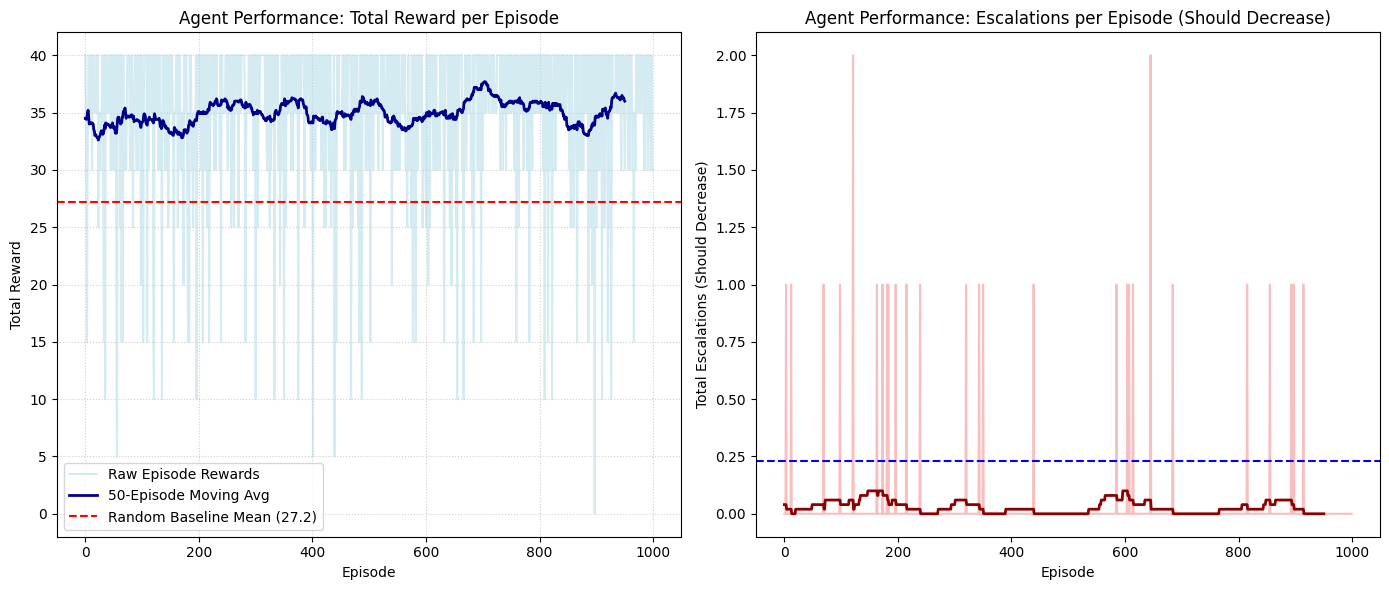


FINAL EVALUATION (100 Episodes):
Random Baseline Avg Reward: 27.2 / Avg Escalations: 0.2
Trained Agent Avg Reward: 28.4 / Avg Escalations: 0.0


In [ ]:
from matplotlib import lines
# --- 1. Safety and Security Measure: Input Validation (Existing Code) ---
def validate_request(request):
    """ Screens user request for harmful or out-of-scope intent."""
    forbidden_words = ["harm", "delete system files", "leak pii"]
    if any(word in request.lower() for word in forbidden_words):
        return False, "Input Validation Failure: Request Violates safety boundaries."
    return True, "Request accepted."

# Example of testing the validation
status, message = validate_request("Onboard Intern Janet Doe")
print(f"Validation Check: {message}")

# --- 2. New Function for baseline/Trained Evaluation ---
def evaluate_policy(q_table_to_use, episodes=100, is_random_baseline=False):
    """Evaluates a policy (trained or random) over a fixed numberof episodes."""

    # Ensure contestants (NUM_TASKS, NUM_ERRORS, NUM_RL_ACTIONS, INITIAL_PLAN) are defined in earlier cells

    eval_rewards = []
    eval_escalations = []

    for _ in range(episodes):
        # Must make a copy of the list, do not modify INITIAL_PLAN directly
        current_plan = list(INITIAL_PLAN) # Use `list()` to create a copy of the list
        total_reward = 0
        total_escalations = 0

        while current_plan:
            task_id, _ = current_plan.pop(0)
            current_error_code = 0
            success = False
            attempts = 0

            # This inner loop ensures we test the policy's primary action choice (no exploration)
            while not success and attempts < 1:
                state_index = get_state_index(task_id, current_error_code)

                if is_random_baseline:
                    # Random Baseline ACtion
                    rl_action = random.randint(0, NUM_RL_ACTIONS - 1)
                else:
                    # Trained Agent Action (Exploitation only)
                    rl_action = np.argmax(q_table_to_use[state_index, :])

                # EXECUTE ATOMIC ACTION
                error_code, failure_report, success = mock_api_call(task_id)
                current_error_code = error_code

                reward = get_reward(rl_action, success)
                total_reward += reward

                if success:
                    break

                if rl_action == 2: # ESCALATE
                    total_escalations += 1
                    # Re-plan only for evaluation (no Q-table update here)
                    new_tasks = planner_adapt(failure_report)
                    if new_tasks is False:
                         current_plan = [] # Halt

                    break # Break inner recovery loop on ESCALATE

                elif rl_action == 0 or rl_action == 1:
                    attempts += 1

        eval_rewards.append(total_reward)
        eval_escalations.append(total_escalations)

    return np.mean(eval_rewards), np.mean(eval_escalations)

# Helper function for smoothing the training curve
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size), 'valid') / window_size
window = 50


# --- 3. Run Evaluation and Plotting (Updated Code) ---

# Calculate Baseline and Final Performance
random_baseline_rewards, random_baseline_escalations = evaluate_policy(Q_TABLE, episodes=100, is_random_baseline=True)
final_policy_rewards, final_policy_escalations = evaluate_policy(Q_TABLE, episodes=100, is_random_baseline=False)

# Smooth the training history for cleaner visualization
smoothed_rewards = moving_average(training_history['rewards'], window)
smoothed_escalations = moving_average(training_history['escalations'], window)


# Generate Plots
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Plot 1: Policy Improvement over time (Rewards)
plt.subplot(1, 2, 1)
# Add raw plot, smoothed plot, and baseline for comparison
plt.plot(training_history['rewards'], label='Raw Episode Rewards', color='lightblue', alpha=0.5)
plt.plot(smoothed_rewards, label=f'{window}-Episode Moving Avg', color='darkblue', linewidth=2)
plt.axhline(random_baseline_rewards, color='red', linestyle='--', label=f'Random Baseline Mean ({random_baseline_rewards:.1f})')

plt.title('Agent Performance: Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend() # <-- Important: Add the legend here!
plt.grid(True, linestyle=':', alpha=0.6)

# Plot 2: Policy Improvement over time (Escalations)
plt.subplot(1, 2, 2)
plt.plot(training_history['escalations'], label='Raw Episode Escalations', color='lightcoral', alpha=0.5)
plt.plot(smoothed_escalations, label=f'{window}-Episode Moving Avg', color='darkred', linewidth=2)
plt.axhline(random_baseline_escalations, color='blue', linestyle='--',  label=f'Random Baseline Mean ({random_baseline_escalations:.1f})')

plt.title('Agent Performance: Escalations per Episode (Should Decrease)')
plt.xlabel('Episode')
plt.ylabel('Total Escalations (Should Decrease)')

plt.tight_layout()
plt.show()

print(f"\nFINAL EVALUATION (100 Episodes):")
print(f"Random Baseline Avg Reward: {random_baseline_rewards:.1f} / Avg Escalations: {random_baseline_escalations:.1f}")
print(f"Trained Agent Avg Reward: {final_policy_rewards:.1f} / Avg Escalations: {final_policy_escalations:.1f}")